In [20]:
import numpy as np
import pandas as pd
import csv
import sys
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
sys.path.append("/home/stef/Tb/reaction_mapping")
from utils import sanitize
from collections import defaultdict

In [2]:
# Was the target found?
expansion_dir = "/home/stef/Tb/bottle/expansions/dvl_to_mvl/2gen_imt_rules_unfiltered/"
starter = 'O=C1CCCCO1'
target = 'C=C1CCCOC1=O'


cpds = pd.read_csv(expansion_dir + 'compounds.tsv', delimiter='\t')
rxns = pd.read_csv(expansion_dir + 'reactions.tsv', delimiter='\t')
# rxns.loc[:,"SMILES equation"] = rxns.loc[:,"SMILES equation"].apply(lambda x : x.split(' '))
# target_in = rxns.loc[:, "SMILES equation"].apply(lambda x : target in x)
# rxns_w_target = rxns[target_in]
# rxns_w_target

In [3]:

def rxns_w_product(pid, rxn_df):
    rxn_df = rxn_df.copy()
    pid += '[c0]'
    rxn_df.loc[:,"ID equation"] = rxn_df.loc[:,"ID equation"].apply(lambda x : x.split('=>')[-1].split(' '))
    product_in = rxn_df.loc[:, "ID equation"].apply(lambda x : pid in x)
    sel_rxns = rxn_df[product_in]
    sel_rxns = list(sel_rxns["ID"])
    return sel_rxns

def reactant_of_rxn(rid, starter_id, rxn_df):
    rxn_df = rxn_df.copy()
    rxn_df.loc[:,"ID equation"] = rxn_df.loc[:,"ID equation"].apply(lambda x : x.split('=>')[0].split(' '))
    reactants = list(rxn_df[rxn_df["ID"] == rid]["ID equation"])[0]
    for elt in reactants:
        if ("pkc" in elt) or ((starter_id in elt)):
            return elt[:-4]

In [4]:
target_id = cpds[cpds["SMILES"] == target]["ID"].to_numpy()[0]
starter_id = cpds[cpds["SMILES"] == starter]["ID"].to_numpy()[0]
gen2_rxns_ids = rxns_w_product(target_id, rxns)
rxns.loc[rxns["ID"].isin(gen2_rxns_ids)]
gen2_reactants = [reactant_of_rxn(elt, starter_id, rxns) for elt in gen2_rxns_ids]
gen1_rxns_ids = [rxns_w_product(elt, rxns) for elt in gen2_reactants]
gen1_reactants = []
for elt in gen1_rxns_ids:
    gen1_reactants.append([reactant_of_rxn(elt2, starter_id, rxns) for elt2 in elt])

pathways = []
for i, elt in enumerate(gen1_reactants):
    temp = []
    for subelt in elt:
        if subelt == starter_id:
            temp.append(gen1_rxns_ids[i][elt.index(subelt)])
    
    if len(temp) > 0:
        for subelt in temp:
            pathways.append((subelt, gen2_rxns_ids[i]))

pathways = list(set(pathways))


In [5]:
pathways

[('pkr0027397', 'pkr0039063'),
 ('pkr0010825', 'pkr0036414'),
 ('pkr0013462', 'pkr0001060'),
 ('pkr0027397', 'pkr0004817'),
 ('pkr0032215', 'pkr0019314')]

In [6]:
rxns = rxns.set_index("ID")
rxns.head()

,Name,ID equation,SMILES equation,Rxn hash,Reaction rules
ID,,,,,
pkr0000001,NaN,(1) FAD_CoF[c0] + (1) pkc0000101[c0] + (1) WAT...,(1) O=C1OC2CCC1O2 + (1) O + (1) Cc1cc2nc3c(=O)...,R0002a09151ea80f2aff90f127d76ff9ecafa5e7dee6d1...,rule0425
pkr0000002,NaN,(2) pkc0000017[c0] + (1) O2[c0] => (1) pkc0013...,(2) NC1CCC(Cl)CO1 + (1) O=O => (1) NC1CC(O)C(C...,R0003468ec19aee3a88c0ebdb5d7c8a06af8ba5b71bf2e...,rule0285_25
pkr0000003,NaN,(1) pkc0000026[c0] + (1) WATER[c0] => (1) pkc0...,(1) CC(C)(COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)...,R0004e240efc8c4ed8ec496725a749dba6a7e6ba4353d0...,rule0822
pkr0000004,NaN,(1) pkc0000026[c0] => (1) pkc0002095[c0],(1) CC(C)(COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)...,R0005c052918b81bdaf7c73b7e61110b06cfe32ea9d1e0...,rule0028_120
pkr0000005,NaN,(1) HI[c0] + (1) pkc0000049[c0] + (1) NAD_CoF[...,(1) O=C1CC2OC2CO1 + (1) NC(=O)c1ccc[n+](C2OC(C...,R0005fe5d1f9a02112c5e02e3f791531d4f51e9d95d673...,rule0841


In [8]:
# Show rules & associated ec numbers
rule_pathways = []
ec_pathways = []
imt_ec_fn = '/home/stef/Tb/reaction_mapping/analysis_data_wrangling/imt_rules_top_ec_numbers.csv'
min_ec_fn = '/home/stef/Tb/reaction_mapping/analysis_data_wrangling/min_rules_top_ec_numbers.csv'
imt2ec = pd.read_csv(imt_ec_fn, delimiter=',')
min2ec = pd.read_csv(min_ec_fn, delimiter=',')
imt2ec = imt2ec.set_index("rule")
min2ec = min2ec.set_index("rule")
for elt in pathways:
    this_rule_path = (rxns.loc[elt[0], ["Reaction rules"]][0], rxns.loc[elt[1], ["Reaction rules"]][0])
    rule_pathways.append(this_rule_path)
    this_ec_path = []
    for rule in this_rule_path:
        if rule in imt2ec.index.to_list():
            this_ec_path.append(imt2ec.loc[rule, "top_3rd_digit"])
        elif rule in min2ec.index.to_list():
            this_ec_path.append(min2ec.loc[rule, "top_3rd_digit"])
        else:
            this_ec_path.append(None)
    ec_pathways.append(this_ec_path)



In [9]:
ec_pathways

[['2.1.1', None],
 [None, '2.1.1'],
 ['2.5.1', None],
 ['2.1.1', None],
 [None, None]]

Get empirical reactions mapped by rules.

In [36]:
mapping_dir = '/home/stef/Tb/reaction_mapping/mapping/results/'
imt_fns = ['mapping_mc_v21_imt_rules_enforce_cof.csv', 'mapping_brenda_imt_rules_enforce_cof.csv', 'mapping_kegg_imt_rules_enforce_cof.csv']
min_mc_fn = 'mapping_mc_v21_min_rules_enforce_cof.csv'
db_keys = [elt.split('_')[1] for elt in imt_fns]
rule2db2rxn = defaultdict(lambda : defaultdict(list))
for i,fn in enumerate(imt_fns):
    with open(mapping_dir + fn, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        for row in reader:
            temp.append(row)
            if len(row) > 1:
                for rule in row[1:]:
                    rule2db2rxn[rule][db_keys[i]].append(row[0])

with open(mapping_dir + min_mc_fn, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        for row in reader:
            temp.append(row)
            if len(row) > 1:
                for rule in row[1:]:
                    rule2db2rxn[rule][db_keys[0]].append(row[0])
        


In [45]:
for i,row in enumerate(rule_pathways):
    for elt in row:
        if len(rule2db2rxn[elt]) > 0:
            print(i, elt, rule2db2rxn[elt])
        elif len(rule2db2rxn[elt.split('_')[0]]) > 0:
            print(i, f"{elt}*", rule2db2rxn[elt.split('_')[0]])
        else:
            print("Unmapped")

print("* Minimal rule mapping")

0 rule0043_12 defaultdict(<class 'list'>, {'mc': ['RXN-11456_reverse', 'RXN-14468_reverse', 'RXN-16336_reverse', 'RXN-12975_reverse', 'RXN-17530_reverse', 'RXN-11456_reverse', 'RXN-14468_reverse', 'RXN-16336_reverse', 'RXN-12975_reverse', 'RXN-17530_reverse'], 'brenda': ['2.1.1.255_1', '2.1.1.281 ()_1'], 'kegg': ['R01972', 'R01973', 'R09939', 'R09940']})
0 rule0288_6* defaultdict(<class 'list'>, {'mc': ['RXN-9305_reverse', 'RXN-9304_reverse', 'MEPROPCOA-FAD-RXN_reverse', 'RXN-9293', 'RXN-9303_reverse', 'RXN-14264_reverse', 'RXN-12572_reverse', 'RXN-12258_reverse']})
1 rule0018_8* defaultdict(<class 'list'>, {'mc': ['CHOLESTENONE-5-BETA-REDUCTASE-RXN_reverse', 'RXN-9840', '2-ENOATE-REDUCTASE-RXN_reverse', 'RXN-5041_reverse', 'RXN-4502_reverse', 'RXN-13476_reverse', 'RXN-17400_reverse', '1.3.1.54-RXN_reverse', 'RXN-4282_reverse', 'RXN-3562_reverse', 'RXN-711_reverse', 'ZEATIN-REDUCTASE-RXN_reverse', 'RXN-17230_reverse', 'RXN-18138_reverse', 'RXN-12295', 'RXN-10095_reverse', 'CORTISONE-BE

In [44]:
pathways

[('pkr0027397', 'pkr0039063'),
 ('pkr0010825', 'pkr0036414'),
 ('pkr0013462', 'pkr0001060'),
 ('pkr0027397', 'pkr0004817'),
 ('pkr0032215', 'pkr0019314')]

In [47]:
# Show chemical formula of reactions
idx = 0
formula_path = []
id_eq_path = []
for elt in pathways[idx]:
    reactants, products = rxns.loc[elt, "SMILES equation"].split('=>')
    reactants = reactants.split(' ')
    reactants = [i for i in reactants if (i != '+') and (i != '')]
    products = products.split(' ')
    products = [i for i in products if (i != '+') and (i != '')]
    reactants_mol = [Chem.MolFromSmiles(reactants[i]) for i in range(1, len(reactants), 2)]
    products_mol = [Chem.MolFromSmiles(products[i]) for i in range(1, len(products), 2)]
    [mol.SetProp('_Name', reactants[int(i * 2)]) for i, mol in enumerate(reactants_mol)]
    [mol.SetProp('_Name', products[int(i * 2)]) for i, mol in enumerate(products_mol)]
    formula_path.append([reactants_mol, products_mol])
    id_eq_path.append(rxns.loc[elt, "ID equation"])

id_eq_path

['(1) dvl[c0] + (1) METHYL_DONOR_CoF[c0] => (1) METHYL_ACCEPTOR_CoF[c0] + (1) pkc0000068[c0]',
 '(1) pkc0000068[c0] + (1) FAD_CoF[c0] => (1) FADH2_CoF[c0] + (1) pkc0015471[c0]']

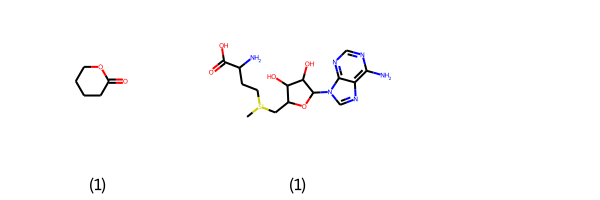

In [48]:
Chem.Draw.MolsToGridImage(formula_path[0][0],legends=[mol.GetProp('_Name') for mol in formula_path[0][0]])

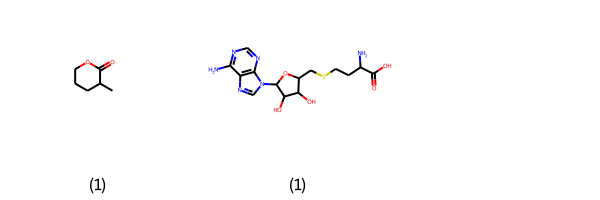

In [49]:
Chem.Draw.MolsToGridImage(formula_path[0][1],legends=[mol.GetProp('_Name') for mol in formula_path[0][1]])

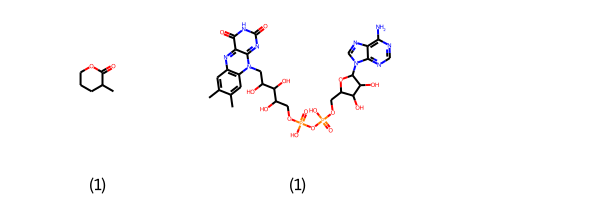

In [50]:
Chem.Draw.MolsToGridImage(formula_path[1][0],legends=[mol.GetProp('_Name') for mol in formula_path[1][0]])

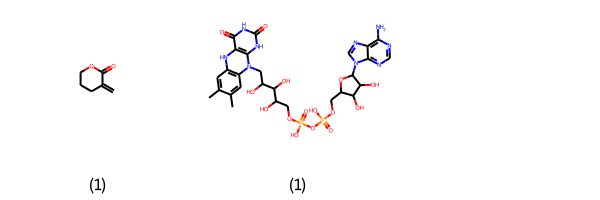

In [51]:
Chem.Draw.MolsToGridImage(formula_path[1][1],legends=[mol.GetProp('_Name') for mol in formula_path[1][1]])

# Scrap

In [183]:


# reactants_of_rxn(rxns, 'pkr0001060' )

In [184]:
# Work backwards to starter
target_id = cpds[cpds["SMILES"] == target]["ID"].to_numpy()[0]
starter_id = cpds[cpds["SMILES"] == starter]["ID"].to_numpy()[0]
last_reactions = rxns_w_product(target_id, rxns)

KeyError: 'ID'

In [ ]:
def factorial(n):
    if n == 1:
        return n
    else:
        return  n * factorial(n-1)
    
factorial(4)

24

In [ ]:
def seq(n, foo):
    if n == 1:
        return [n]
    else:
        return [n] + seq(n-1, foo)
    
foo = []
seq(2, foo)

[2, 1]

In [ ]:
def seqseq(n, foo):
    if n == 1:
        return []
    else:
        this_bar = []
        for i in range(n):
            new_foo = foo.copy()
            
            new_foo.append(i)
            temp = seqseq(n-1, new_foo)
            new_foo += temp
            # print(n, new_foo, temp)
            if len(temp) == 0:
                this_bar.append(new_foo)
            else:
                for elt in temp:
                    this_bar.append(elt)
        return this_bar
foo = []
bar = []
out = seqseq(4, foo)

In [ ]:
def collect_paths(sub, starter, path, df):
    if sub == starter:
        return []
    else:
        this_level = []
        rxns = rxns_w_product(sub, df)
        for elt in rxns:
            new_path = path.copy()
            new_path.append(sub)
            new_sub = reactant_of_rxn(elt, df)
            temp = collect_paths(new_sub, starter, new_path, df)
            new_path.append(temp)
            if len(temp) == 0:
                this_level.append(new_path)
            else:
                for elt2 in temp:
                    this_level.append(elt2)
        
        return this_level
        
target_id = cpds[cpds["SMILES"] == target]["ID"].to_numpy()[0]
starter_id = cpds[cpds["SMILES"] == starter]["ID"].to_numpy()[0]
path = []
collect_paths(target_id, starter_id, path, rxns)

KeyError: 'ID'